In [ ]:
import os,time,sys,warnings
import progressbar
import tensorflow as tf
import numpy as np
import pandas as pd
import keras
from keras.utils.data_utils import get_file
from keras.backend import set_session
from keras import layers
import matplotlib.pyplot as plt
from collections import Counter
from keras.preprocessing.image import load_img
from nltk.tokenize import word_tokenize
warnings.filterwarnings("ignore")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
zip_ref=zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/flickr8/Flickr8k_Dataset.zip',"r")
zip_ref.extractall('/tmp')
zip_ref.close()


In [ ]:
zip_ref=zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/flickr8/Flickr8k_text.zip','r')
zip_ref.extractall('/tmp')
zip_ref.close()

DATA

In [ ]:
dir_Flickr_text="/tmp/Flickr8k.token.txt"
dir_Flickr_jpg="/tmp/Flicker8k_Dataset"

In [ ]:
print(len(dir_Flickr_text))
print(10*"*")
jpgs = os.listdir(dir_Flickr_jpg)
print("The number of jpg flies in Flicker30k: {}".format(len(jpgs)))

23
**********
The number of jpg flies in Flicker30k: 8091


In [ ]:
file = open(dir_Flickr_text,'r')
text = file.read()
file.close()


datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#")
    datatxt.append(w + [col[1].lower()])

df_txt = pd.DataFrame(datatxt,columns=["filename","index","caption"])
print(df_txt.head(10))

uni_filenames = np.unique(df_txt.filename.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")
Counter(Counter(df_txt.filename.values).values())

                    filename index  \
0  1000268201_693b08cb0e.jpg     0   
1  1000268201_693b08cb0e.jpg     1   
2  1000268201_693b08cb0e.jpg     2   
3  1000268201_693b08cb0e.jpg     3   
4  1000268201_693b08cb0e.jpg     4   
5  1001773457_577c3a7d70.jpg     0   
6  1001773457_577c3a7d70.jpg     1   
7  1001773457_577c3a7d70.jpg     2   
8  1001773457_577c3a7d70.jpg     3   
9  1001773457_577c3a7d70.jpg     4   

                                             caption  
0  a child in a pink dress is climbing up a set o...  
1              a girl going into a wooden building .  
2   a little girl climbing into a wooden playhouse .  
3  a little girl climbing the stairs to her playh...  
4  a little girl in a pink dress going into a woo...  
5         a black dog and a spotted dog are fighting  
6  a black dog and a tri-colored dog playing with...  
7  a black dog and a white dog with brown spots a...  
8  two dogs of different breeds looking at each o...  
9    two dogs on pavement movin

Counter({5: 8092})

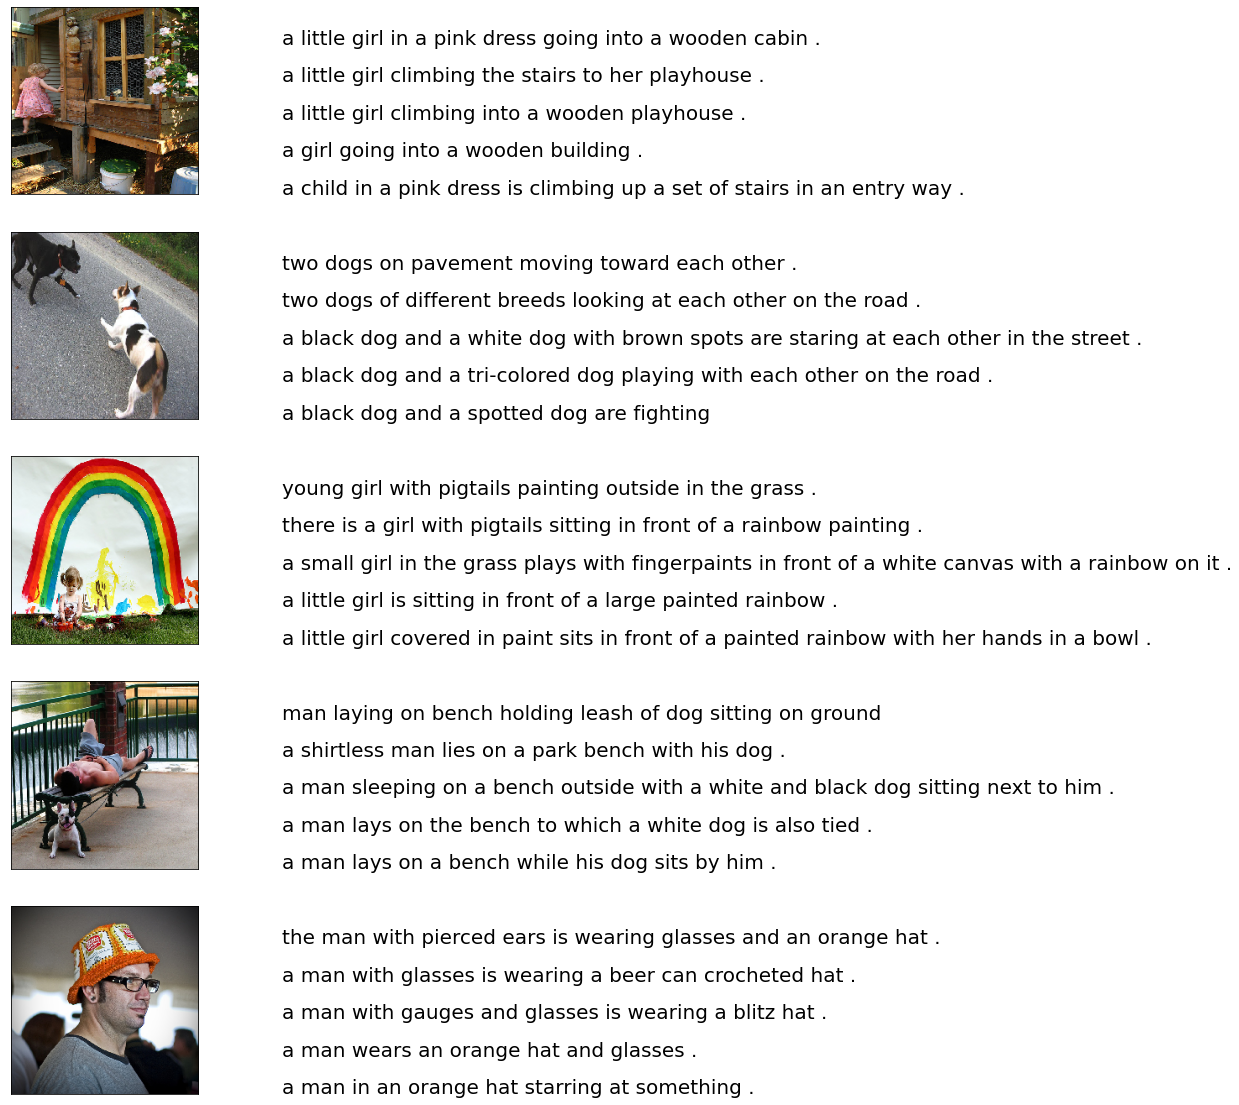

In [ ]:
from keras.preprocessing.image import load_img,img_to_array
npic=5
npix=224
target_size=(npix,npix,3)

count=1
fig=plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[:npic]:
    filename=dir_Flickr_jpg+"/"+jpgfnm
    captions=list(df_txt["caption"].loc[df_txt["filename"]==jpgfnm].values)
    image_load=load_img(filename,target_size=target_size)

    ax=fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count+=1
    
    ax=fig.add_subplot(npic,2,count)
    plt.axis("off")
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i,caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count+=1
plt.show()


In [ ]:
def df_word(df_txt):
    vocabulary=[]
    for i in range(len(df_txt)):
        temp=df_txt.iloc[i,2]
        vocabulary.extend(temp.split())
    print(len(set(vocabulary)))
    ct=Counter(vocabulary)
    dfword=pd.DataFrame({"word":list(ct.keys()),"count":list(ct.values())})
    dfword=dfword.sort_values("count",ascending=False)
    dfword=dfword.reset_index()[["word","count"]]
    return (dfword)
dfword=df_word(df_txt)
dfword.head(3)

8918


,word,count
0,a,62989
1,.,36581
2,in,18975


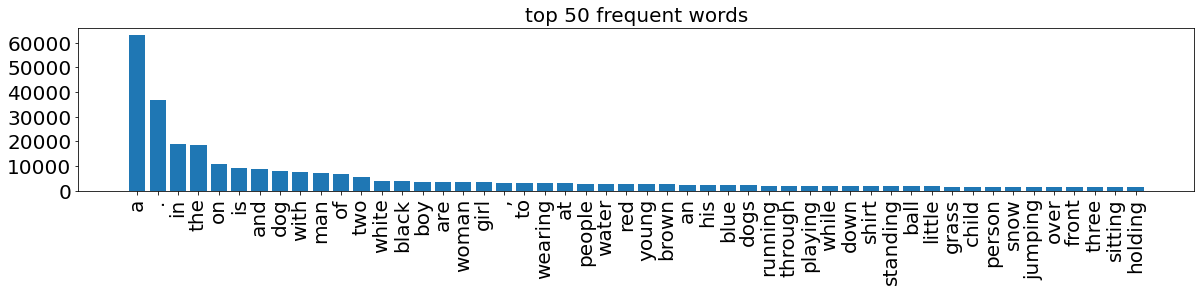

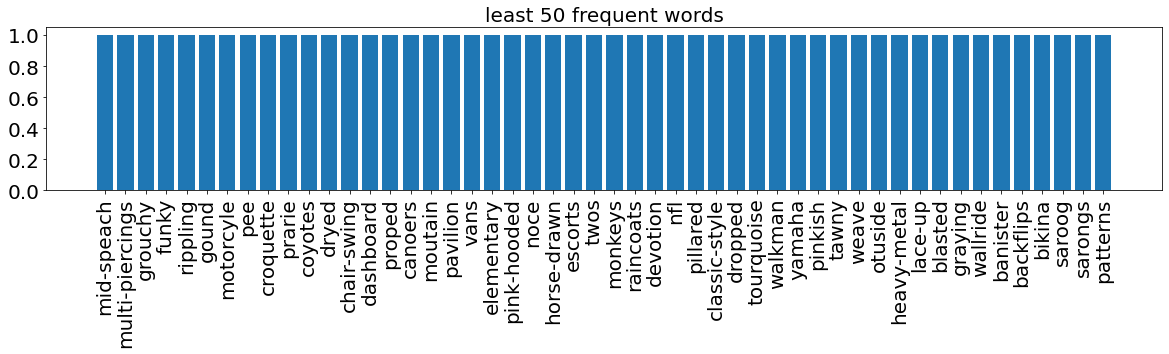

In [ ]:
topn=50
def plthist(dfsub,title="The top 50 most frequently appearing in flickr8"):
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()
plthist(dfword.iloc[:topn,:],title="top 50 frequent words")
plthist(dfword.iloc[-topn:,:],title="least 50 frequent words")


In [ ]:
#functions for removing pnctuations,single word, numeric 
import string
def remove_punctuation(text_original):
    return text_original.translate(str.maketrans('','',string.punctuation))
def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)
def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)

In [ ]:
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)
with progressbar.ProgressBar(max_value=len(df_txt.caption.values)) as bar:
    for i, caption in enumerate(df_txt.caption.values):
        newcaption = text_clean(caption)
        df_txt["caption"].iloc[i] = newcaption
        bar.update(i)


100% (40460 of 40460) |##################| Elapsed Time: 0:00:18 Time:  0:00:18


8763


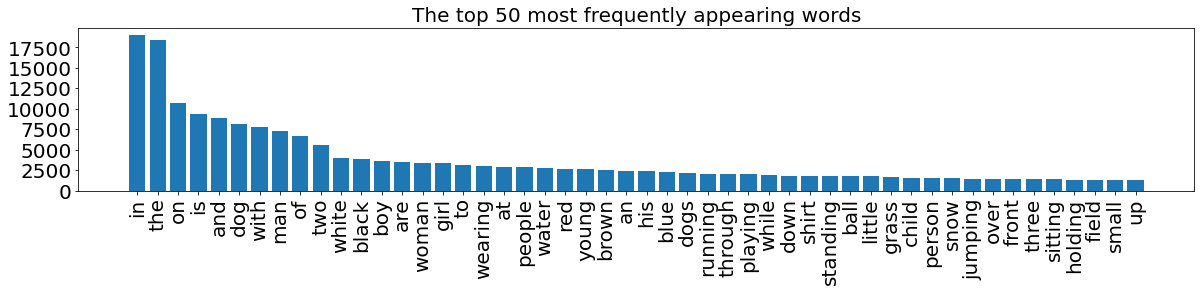

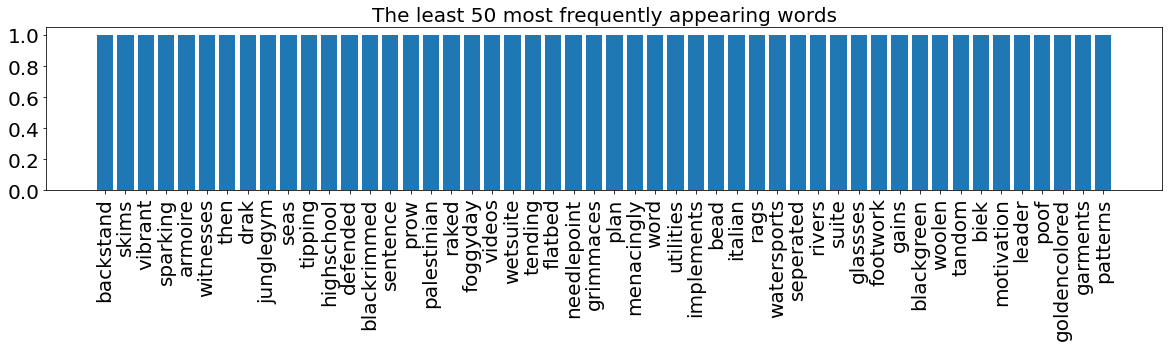

In [ ]:
dfword = df_word(df_txt)
plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

In [ ]:
from copy import copy
def add_start_end_seq_token(captions):
    caps = []
    for txt in captions:
        txt = 'startseq ' + txt + ' endseq'
        caps.append(txt)
    return(caps)
df_txt0 = copy(df_txt)
df_txt0["caption"] = add_start_end_seq_token(df_txt["caption"])
print(df_txt0.head(5))
del df_txt

                    filename index  \
0  1000268201_693b08cb0e.jpg     0   
1  1000268201_693b08cb0e.jpg     1   
2  1000268201_693b08cb0e.jpg     2   
3  1000268201_693b08cb0e.jpg     3   
4  1000268201_693b08cb0e.jpg     4   

                                             caption  
0  startseq  child in pink dress is climbing up s...  
1   startseq  girl going into wooden building endseq  
2  startseq  little girl climbing into wooden pla...  
3  startseq  little girl climbing the stairs to h...  
4  startseq  little girl in pink dress going into...  


In [ ]:
from keras.applications import vgg16

model=vgg16.VGG16(include_top=True,weights=None)
model.load_weights("/content/drive/MyDrive/Colab Notebooks/flickr8/vgg16_weights_tf_dim_ordering_tf_kernels.h5")
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
from keras import models
# model._layers.pop()
model = models.Model(inputs=model.inputs, outputs=model.layers[-2].output)
## show the deep learning model
model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
from keras.preprocessing.image import load_img,img_to_array
from keras.applications.vgg16 import preprocess_input
from collections import OrderedDict


images=OrderedDict()
npix=224
target_size = (npix,npix,3)
with progressbar.ProgressBar(max_value=len(jpgs)) as bar:
    for i,name in enumerate(jpgs):
        # load an image from file
        filename = dir_Flickr_jpg + '/' + name
        image = load_img(filename, target_size=target_size)
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        nimage = preprocess_input(image)
        y_pred = model.predict(nimage.reshape( (1,) + nimage.shape[:3]))
        images[name] = y_pred.flatten()
        bar.update(i)
    print(i,filename)

100% (8091 of 8091) |####################| Elapsed Time: 1:23:03 Time:  1:23:03


8090 /tmp/Flicker8k_Dataset/3145869775_85dfae43bd.jpg


In [ ]:
dimages,keepindex=[],[]
nd=(df_txt0["index"].values)
b=[int(i)==0 for i in nd]
df_txt0 = df_txt0.loc[df_txt0["index"].values == "0",: ]

for i, fnm in enumerate(df_txt0.filename):
    if fnm in images.keys():
        dimages.append(images[fnm])
        keepindex.append(i)
        # print(i,fnm)
        
fnames = df_txt0["filename"].iloc[keepindex].values
dcaptions = df_txt0["caption"].iloc[keepindex].values
print(dcaptions)
dimages = np.array(dimages)
print(df_txt0["index"][:5])

['startseq  child in pink dress is climbing up set of stairs in an entry way endseq'
 'startseq  black dog and spotted dog are fighting endseq'
 'startseq  little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq'
 ...
 'startseq  grey bird stands majestically on beach while waves roll in endseq'
 'startseq  person stands near golden walls endseq'
 'startseq  man in pink shirt climbs rock face endseq']
0     0
5     0
10    0
15    0
20    0
Name: index, dtype: object


In [ ]:
from keras.preprocessing.text import Tokenizer
## the maximum number of words in dictionary
count_words=22000
#nb_words = 31782
tokenizer = Tokenizer(num_words=8000)
tokenizer.fit_on_texts(dcaptions)
vocab_size = len(tokenizer.word_index) + 1
print("vocabulary size : {}".format(vocab_size))
dtexts = tokenizer.texts_to_sequences(dcaptions)
print(dtexts[:5])

vocabulary size : 4476
[[1, 38, 3, 66, 144, 7, 124, 52, 406, 9, 367, 3, 24, 2351, 522, 2], [1, 12, 8, 5, 752, 8, 17, 368, 2], [1, 48, 15, 170, 3, 584, 101, 3, 41, 9, 551, 1198, 11, 55, 213, 3, 1076, 2], [1, 10, 621, 6, 150, 27, 23, 8, 101, 46, 112, 2], [1, 10, 3, 24, 82, 96, 1199, 19, 162, 2]]


In [ ]:
prop_test, prop_val = 0.2, 0.2 

N = len(dtexts)
Ntest, Nval = int(N*prop_test), int(N*prop_val)

def split_test_val_train(dtexts,Ntest,Nval):
    return(dtexts[:Ntest], 
           dtexts[Ntest:Ntest+Nval],  
           dtexts[Ntest+Nval:])

dt_test,  dt_val, dt_train   = split_test_val_train(dtexts,Ntest,Nval)
di_test,  di_val, di_train   = split_test_val_train(dimages,Ntest,Nval)
fnm_test,fnm_val, fnm_train  = split_test_val_train(fnames,Ntest,Nval)

In [ ]:
maxlen = np.max([len(text) for text in dtexts])
print(maxlen)

30


In [ ]:
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def preprocessing(dtexts,dimages):
    N = len(dtexts)
    print("# captions/images = {}".format(N))

    assert(N==len(dimages))
    Xtext, Ximage, ytext = [],[],[]
    for text,image in zip(dtexts,dimages):

        for i in range(1,len(text)):
            in_text, out_text = text[:i], text[i]
            in_text = pad_sequences([in_text],maxlen=maxlen).flatten()
            out_text = to_categorical(out_text,num_classes = vocab_size)

            Xtext.append(in_text)
            Ximage.append(image)
            ytext.append(out_text)
    print(Xtext)
    print(ytext)
    Xtext  = np.array(Xtext)
    Ximage = np.array(Ximage)
    ytext  = np.array(ytext)
    print(" {} {} {}".format(Xtext.shape,Ximage.shape,ytext.shape))
    return(Xtext,Ximage,ytext)


Xtext_train, Ximage_train, ytext_train = preprocessing(dt_train,di_train)
Xtext_val,   Ximage_val,   ytext_val   = preprocessing(dt_val,di_val)
print(Xtext_train.shape)
print(Xtext_val.shape)

# pre-processing is not necessary for testing data

# captions/images = 4855


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
         11,   24,   82,   31,  680,    6, 1342,    3], dtype=int32), array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    1,   13,   11,
         24,   82,   31,  680,    6, 1342,    3,    4], dtype=int32), array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    1,   13,   11,   24,
         82,   31,  680,    6, 1342,    3,    4,  505], dtype=int32), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1], dtype=int32), array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 10], dtype=int32), array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 10,  7], dtype=int32), array([  0,   0,   0,   0,   0

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



This model takes two inputs:

4096-dimensional image features from pre-trained VGG model
tokenized captions up to tth word.
The single output is:

tokenized t+1th word of caption

https://fairyonice.github.io/Develop_an_image_captioning_deep_learning_model_using_Flickr_8K_data.html

[Image] 4096-dimensional image features from pre-trained VGG model
The image feature is passed to fully connected layer with 256 hidden units.
[Caption up to t] tokenized captions up to tth word.

The tokenized caption up to tth time point is passed to embedding layer where each word is represented with a "dim_embedding" dimensional vector. This means that a single caption is represented as many time series of length "max_len".
The time series are passed to LSTM with 256 hidden states, and then a single output at the final time point is passed to the higher layer.
The networks are merged by simply adding the two vectors of size 256.

The vector of length 256 is passed to two dense layers and the final dense layer return probability that the t+1st word is kth word in the vocabulary (k=1,...,4476).

In [ ]:
from keras import layers
print(vocab_size)
## image feature

dim_embedding = 64

input_image = layers.Input(shape=(Ximage_train.shape[1],))
fimage = layers.Dense(256,activation='relu',name="ImageFeature")(input_image)
## sequence model
input_txt = layers.Input(shape=(maxlen,))
ftxt = layers.Embedding(vocab_size,dim_embedding, mask_zero=True)(input_txt)
ftxt = layers.LSTM(256,name="CaptionFeature")(ftxt)
## combined model for decoder
decoder = layers.add([ftxt,fimage])
decoder = layers.Dense(256,activation='relu')(decoder)
output = layers.Dense(vocab_size,activation='softmax')(decoder)
model1 = models.Model(inputs=[input_image, input_txt],outputs=output)

model1.compile(loss='categorical_crossentropy', optimizer='adam')

print(model1.summary())

4476
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 30, 64)       286464      ['input_3[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 CaptionFeature (LSTM)          (None, 256)          328704      ['embedding[0][0]']              
                                                                                       

In [ ]:
start = time.time()
# Create checkpoint callback
# cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
#                                                 save_weights_only=True,
#                                                 verbose=2)
hist = model1.fit([Ximage_train, Xtext_train], ytext_train,epochs=7, verbose=2,batch_size=64,validation_data=([Ximage_val, Xtext_val], ytext_val))
                # ,callbacks = [cp_callback])
end = time.time()
print("TIME TOOK {:3.2f}MIN".format((end - start )/60))

Epoch 1/7
776/776 - 187s - loss: 5.3026 - val_loss: 4.7263 - 187s/epoch - 241ms/step
Epoch 2/7
776/776 - 188s - loss: 4.3192 - val_loss: 4.4504 - 188s/epoch - 242ms/step
Epoch 3/7
776/776 - 205s - loss: 3.8524 - val_loss: 4.3872 - 205s/epoch - 264ms/step
Epoch 4/7
776/776 - 202s - loss: 3.5371 - val_loss: 4.4467 - 202s/epoch - 260ms/step
Epoch 5/7
776/776 - 162s - loss: 3.2658 - val_loss: 4.5650 - 162s/epoch - 209ms/step
Epoch 6/7
776/776 - 154s - loss: 3.0201 - val_loss: 4.7418 - 154s/epoch - 198ms/step
Epoch 7/7
776/776 - 153s - loss: 2.7773 - val_loss: 4.9796 - 153s/epoch - 198ms/step
TIME TOOK 21.43MIN


In [ ]:
print(Ximage_train.shape,Xtext_train.shape,ytext_train.shape)

(49631, 4096) (49631, 30) (49631, 4476)


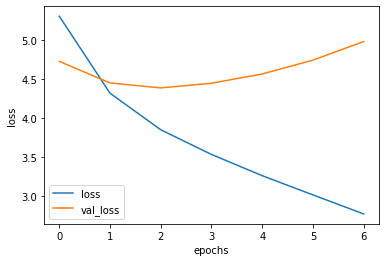

In [ ]:
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

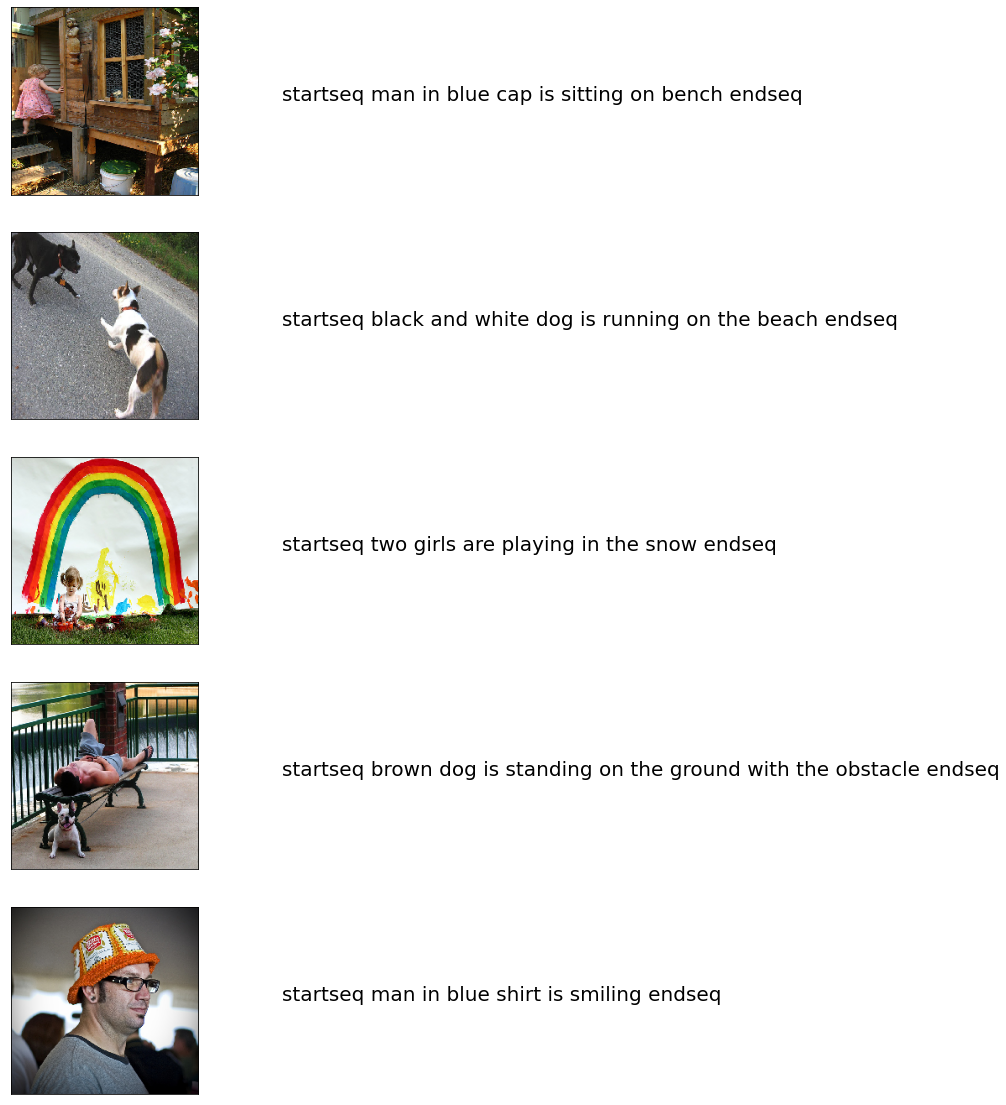

In [ ]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])
def predict_caption(image):
    '''
    image.shape = (1,4462)
    '''

    in_text = 'startseq'

    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],maxlen)
        yhat = model1.predict([image,sequence],verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]
        in_text += " " + newword
        if newword == "endseq":
            break
    return(in_text)



npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm, image_feature in zip(fnm_test[:npic],di_test[:npic]):
    ## images 
    filename = dir_Flickr_jpg + '/' + jpgfnm
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0,0.5,caption,fontsize=20)
    count += 1

plt.show()


In [ ]:
from nltk.translate.bleu_score import sentence_bleu
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])


nkeep = 5
pred_good, pred_bad, bleus = [], [], [] 
count = 0 
for jpgfnm, image_feature, tokenized_text in zip(fnm_test,di_test,dt_test):
    count += 1
    if count % 200 == 0:
        print("  {:4.2f}% is done..".format(100*count/float(len(fnm_test))))
    
    caption_true = [ index_word[i] for i in tokenized_text ]     
    caption_true = caption_true[1:-1] ## remove startreg, and endreg
    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    caption = caption.split()
    caption = caption[1:-1]## remove startreg, and endreg
    
    bleu = sentence_bleu([caption_true],caption)
    bleus.append(bleu)
    if bleu > 0.7 and len(pred_good) < nkeep:
        pred_good.append((bleu,jpgfnm,caption_true,caption))
    elif bleu < 0.3 and len(pred_bad) < nkeep:
        pred_bad.append((bleu,jpgfnm,caption_true,caption))

  12.36% is done..
  24.72% is done..
  37.08% is done..
  49.44% is done..
  61.80% is done..
  74.17% is done..
  86.53% is done..
  98.89% is done..


Bad Caption


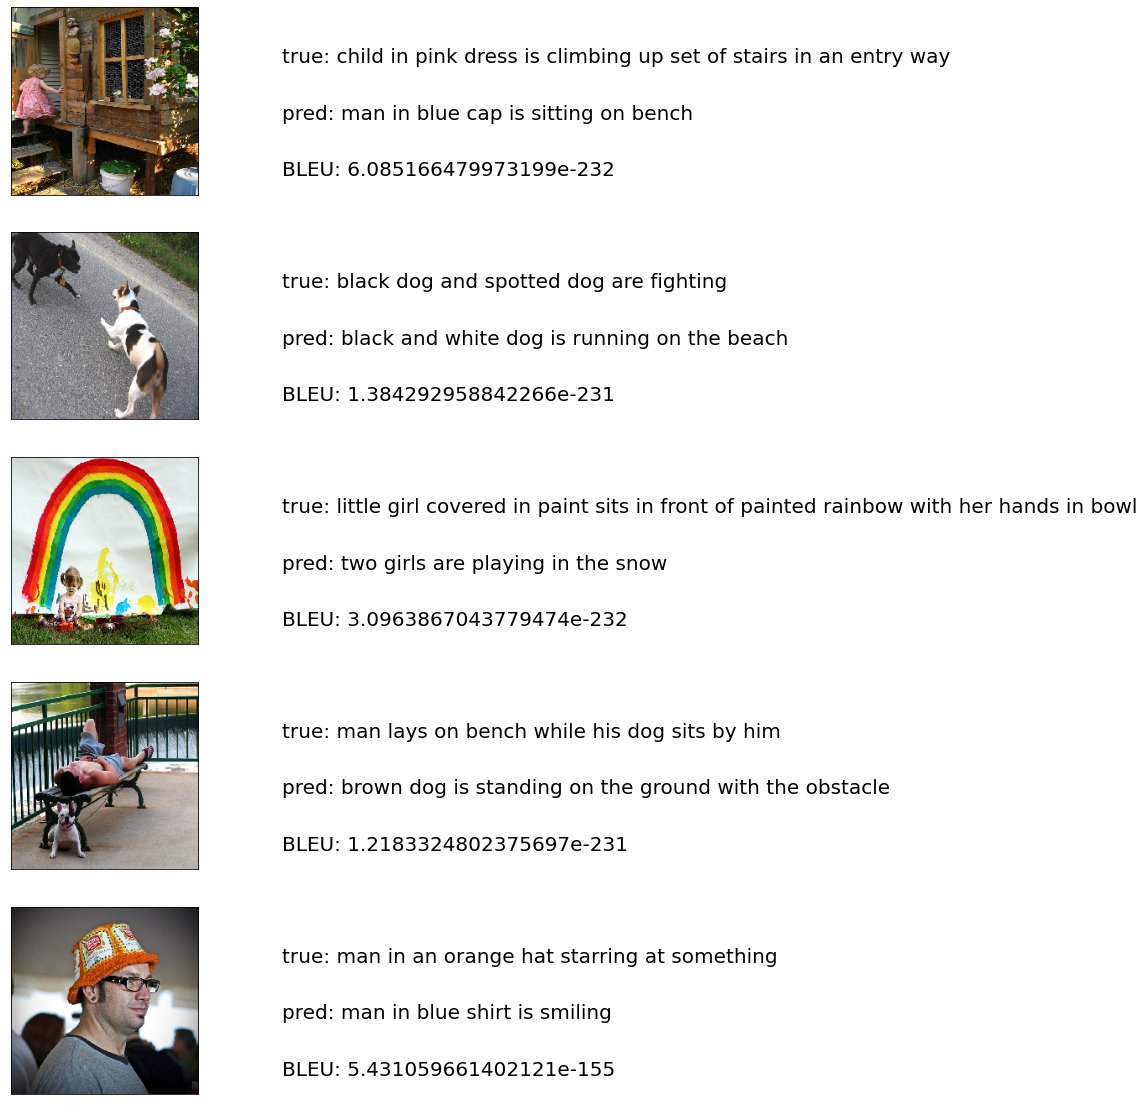

Good Caption


<Figure size 720x1440 with 0 Axes>

In [33]:
def plot_images(pred_bad):
    def create_str(caption_true):
        strue = ""
        for s in caption_true:
            strue += " " + s
        return(strue)
    npix = 224
    target_size = (npix,npix,3)    
    count = 1
    fig = plt.figure(figsize=(10,20))
    npic = len(pred_bad)
    for pb in pred_bad:
        bleu,jpgfnm,caption_true,caption = pb
        ## images 
        filename = dir_Flickr_jpg + '/' + jpgfnm
        image_load = load_img(filename, target_size=target_size)
        ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        caption_true = create_str(caption_true)
        caption = create_str(caption)
        
        ax = fig.add_subplot(npic,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.text(0,0.7,"true:" + caption_true,fontsize=20)
        ax.text(0,0.4,"pred:" + caption,fontsize=20)
        ax.text(0,0.1,"BLEU: {}".format(bleu),fontsize=20)
        count += 1
    plt.show()

print("Bad Caption")
plot_images(pred_bad)
print("Good Caption")
plot_images(pred_good)